<a href="https://colab.research.google.com/github/JoeVal5/CIS_5367_HJMNS/blob/main/Presentation1_v1.ipynb%20-%20Joe%20Additional%20updates" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Spark init#save the files in the g drive folder - first two commands
!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz 
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/default-java"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!head -5 /content/drive/MyDrive/data/zip_code_market_tracker.tsv000

period_begin	period_end	period_duration	region_type	region_type_id	table_id	is_seasonally_adjusted	region	city	state	state_code	property_type	property_type_id	median_sale_price	median_sale_price_mom	median_sale_price_yoy	median_list_price	median_list_price_mom	median_list_price_yoy	median_ppsf	median_ppsf_mom	median_ppsf_yoy	median_list_ppsf	median_list_ppsf_mom	median_list_ppsf_yoy	homes_sold	homes_sold_mom	homes_sold_yoy	pending_sales	pending_sales_mom	pending_sales_yoy	new_listings	new_listings_mom	new_listings_yoy	inventory	inventory_mom	inventory_yoy	months_of_supply	months_of_supply_mom	months_of_supply_yoy	median_dom	median_dom_mom	median_dom_yoy	avg_sale_to_list	avg_sale_to_list_mom	avg_sale_to_list_yoy	sold_above_list	sold_above_list_mom	sold_above_list_yoy	price_drops	price_drops_mom	price_drops_yoy	off_market_in_two_weeks	off_market_in_two_weeks_mom	off_market_in_two_weeks_yoy	parent_metro_region	parent_metro_region_metro_code	last_updated
2017-07-01	2017-09-30	90	zip code	2

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/data/zip_code_market_tracker.tsv000', sep='\t',header=True)

In [ ]:
df.show(5)

+------------+----------+---------------+-----------+--------------+--------+----------------------+---------------+----+--------+----------+--------------------+----------------+-----------------+---------------------+---------------------+-----------------+---------------------+---------------------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+----------+--------------------+--------------------+-------------+--------------------+--------------------+------------+--------------------+--------------------+---------+--------------------+--------------------+----------------+--------------------+--------------------+----------+--------------+--------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-----------+---------------+---------------+-----------------------+---------------------------+---------------------------+-----------

In [ ]:
df_2 = df.drop("region_type","region_type_id","is_seasonally_adjusted","city","table_id","period_duration","months_of_supply","price_drops","median_sale_price_mom", "median_sale_price_yoy","median_list_price_mom","median_list_price_yoy","median_ppsf_mom","median_ppsf_yoy","median_list_ppsf_mom","median_list_ppsf_yoy","homes_sold_mom","homes_sold_yoy", "pending_sales_mom","pending_sales_yoy","new_listings_mom","new_listings_yoy","inventory_mom","inventory_yoy","months_of_supply_mom","months_of_supply_yoy","median_dom_mom","median_dom_yoy","avg_sale_to_list_mom","avg_sale_to_list_yoy","sold_above_list_mom","sold_above_list_yoy","price_drops_mom","price_drops_yoy","off_market_in_two_weeks_mom","off_market_in_two_weeks_yoy")

In [ ]:
df_2.show(5)

+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+-------------------+-----------------------+-------------------+------------------------------+-------------------+
|period_begin|period_end|         region|   state|state_code|       property_type|property_type_id|median_sale_price|median_list_price|       median_ppsf|  median_list_ppsf|homes_sold|pending_sales|new_listings|inventory|median_dom|   avg_sale_to_list|    sold_above_list|off_market_in_two_weeks|parent_metro_region|parent_metro_region_metro_code|       last_updated|
+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+------------

In [ ]:
import pyspark.sql.functions as func

In [ ]:
#Distinct count of states in Redfin Dataset
df_states = df_2.select("state_code").distinct().count()
df_states

47

In [ ]:
#Calculating difference of list and sale price and the percentage of that difference
df_3 = df_2.withColumn('DiffOfList&SalePrice', df_2.median_sale_price - df_2.median_list_price)

In [ ]:
df_3.show(5)

+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+-------------------+-----------------------+-------------------+------------------------------+-------------------+--------------------+
|period_begin|period_end|         region|   state|state_code|       property_type|property_type_id|median_sale_price|median_list_price|       median_ppsf|  median_list_ppsf|homes_sold|pending_sales|new_listings|inventory|median_dom|   avg_sale_to_list|    sold_above_list|off_market_in_two_weeks|parent_metro_region|parent_metro_region_metro_code|       last_updated|DiffOfList&SalePrice|
+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+-

In [ ]:
from pyspark.sql.functions import *
import datetime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import sum, col, desc

In [ ]:
#Grouping by period begin and calculating average median sale price
df_4 = df_3.groupBy(year('period_begin'),).agg({'median_sale_price':'avg'}).sort(desc(year(df_3.period_begin)))
df_4.show(5)

+------------------+----------------------+
|year(period_begin)|avg(median_sale_price)|
+------------------+----------------------+
|              2021|    401835.58340094466|
|              2020|     362584.1021330095|
|              2019|    327522.84003192815|
|              2018|     316829.5468317408|
|              2017|      299386.425371486|
+------------------+----------------------+
only showing top 5 rows



In [ ]:
#Grouping by state and calculating average median sale price
df_5 = df_3.groupBy('state_code').agg({'median_sale_price':'avg'}).sort(desc('state_code'))
#df_5.show()

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import datetime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import sum, col, desc, avg
from pyspark.sql.functions import lit

In [ ]:
#Calculating difference between median sale price

my_window = Window.partitionBy().orderBy("period_begin")

df_3 = df_3.withColumn("prev_value", F.lag("median_sale_price").over(my_window))
df_3 = df_3.withColumn("diff", F.when(F.isnull(df_3.median_sale_price - df_3.prev_value), 0)
                              .otherwise(df_3.median_sale_price - df_3.prev_value))

#df_3.show()

In [ ]:
#Spliting Region Column and add a new column named zip code
from pyspark.sql.functions import split
 
df_zipcode = df_3.withColumn("ZIP_Code", split(col("region"), ": ").getItem(1))
df_zipcode.show(5)

+------------+----------+---------------+-------------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+-------------------+-----------------------+-------------------+------------------------------+-------------------+--------------------+----------+---------+--------+
|period_begin|period_end|         region|        state|state_code|       property_type|property_type_id|median_sale_price|median_list_price|       median_ppsf|  median_list_ppsf|homes_sold|pending_sales|new_listings|inventory|median_dom|   avg_sale_to_list|    sold_above_list|off_market_in_two_weeks|parent_metro_region|parent_metro_region_metro_code|       last_updated|DiffOfList&SalePrice|prev_value|     diff|ZIP_Code|
+------------+----------+---------------+-------------+----------+--------------------+----------------+-----------------+-----------------+------------

In [ ]:
df_avg_by_zip =df_zipcode.groupBy("ZIP_Code",year('period_begin')).agg({'median_sale_price':'avg'}).sort("ZIP_Code",(year(df_zipcode.period_begin)))
df_avg_by_zip.show(5)

+--------+------------------+----------------------+
|ZIP_Code|year(period_begin)|avg(median_sale_price)|
+--------+------------------+----------------------+
|   00501|              2012|              180000.0|
|   00501|              2013|              255000.0|
|   00501|              2015|              239770.0|
|   00501|              2017|              155367.0|
|   00501|              2018|              325000.0|
+--------+------------------+----------------------+
only showing top 5 rows



In [ ]:
df_zipcode_2 = df_zipcode.select('Zip_Code',year('period_begin'),'median_sale_price')
#df_zipcode_2.show(5)
df_avg_by_zip =df_zipcode_2.groupBy("ZIP_Code").pivot('year(period_begin)').agg({'median_sale_price':'avg'}).sortby
df_avg_by_zip.show(5)

+--------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|ZIP_Code|              2012|             2013|              2014|              2015|              2016|              2017|              2018|              2019|             2020|              2021|
+--------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|   64747|           84600.0|87279.16666666667|           90094.0|        107729.375|133957.14285714287|118318.33333333333| 145698.2142857143|168377.08333333334|161435.7142857143|197565.21739130435|
|   27248|              null|             null| 72294.42857142857| 93358.33333333333|128041.66666666667|           82375.0|123552.33333333333|111979.16666666667|         108662.5|          143650.0|
|   3

In [ ]:
#Counting distint zip code
zip_count = df_3.select('region').distinct().count()
zip_count


18817

In [ ]:
#Grouping by state and calculating average difference of median sale price
df_6 = df_3.groupBy('state_code').agg({'diff':'avg'}).sort(desc('state_code'))
df_6.show()

+----------+-------------------+
|state_code|          avg(diff)|
+----------+-------------------+
|        WV|-110408.55942776735|
|        WI|-122563.16650400459|
|        WA| 59871.220940182735|
|        VT| -50599.69678308375|
|        VA|  52924.34346192212|
|        UT| -9981.502163889674|
|        TX| -62635.91684831851|
|        TN| -107012.4056138824|
|        SC| -91005.09704286697|
|        RI| -9225.830760884783|
|        PA| -95261.13769621917|
|        OR|  6864.239373305035|
|        OK| -147332.9635285987|
|        OH|-128705.95788492034|
|        NY| 119268.69354289245|
|        NV|-23636.838470910752|
|        NM|  29495.59345412994|
|        NJ|  33633.41153868969|
|        NH| -37732.71059327168|
|        NE|-104309.95110033857|
+----------+-------------------+
only showing top 20 rows



Text(0.5, 1.0, 'Date Vs. Median Sale Price of Redfin Data')

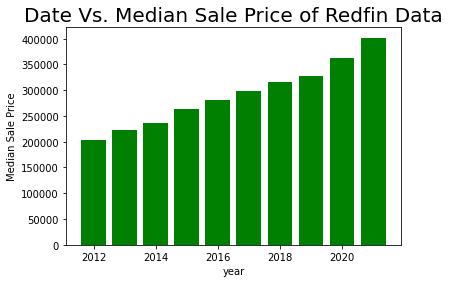

In [ ]:
# convert dataframe to dictionary 
# Visualuizing Date vs. Median Sale Price of Redfin Data
import matplotlib.pyplot as plt
dict = df_4.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='g')
plt.xlabel("year",fontsize=10)
plt.ylabel("Median Sale Price",fontsize=10)
plt.title("Date Vs. Median Sale Price of Redfin Data",fontsize=20)

In [ ]:
#Grouping by state_code and calculating sum of homes sold
df_7 = df_3.groupBy('state_code').agg({'homes_sold':'sum'}).sort(desc('state_code'))
df_7.show()

+----------+---------------+
|state_code|sum(homes_sold)|
+----------+---------------+
|        WV|       231252.0|
|        WI|      3154496.0|
|        WA|      6200008.0|
|        VT|       341600.0|
|        VA|      5122254.0|
|        UT|      2483498.0|
|        TX|    1.6001554E7|
|        TN|      4232576.0|
|        SC|      3155930.0|
|        RI|       831618.0|
|        PA|      6835910.0|
|        OR|      3433796.0|
|        OK|      2358712.0|
|        OH|      7672028.0|
|        NY|      6753402.0|
|        NV|      3229686.0|
|        NM|       157080.0|
|        NJ|      5826306.0|
|        NH|      1188340.0|
|        NE|      1069648.0|
+----------+---------------+
only showing top 20 rows



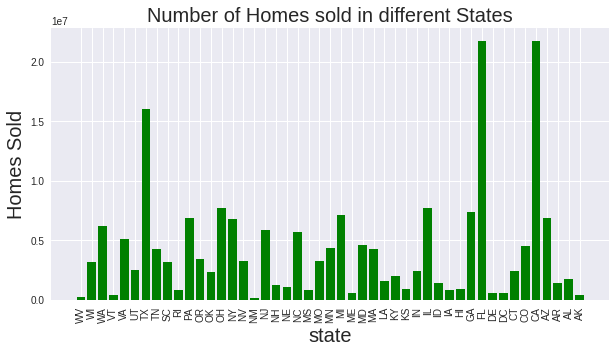

In [ ]:
# convert dataframe to dictionary 
# Visualizing number of homes sold in different states
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

dict = df_7.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='g')
plt.xlabel("state",fontsize=20)
plt.xticks(rotation=90)
plt.ylabel("Homes Sold",fontsize=20)
plt.title("Number of Homes sold in different States",fontsize=20)
plt.gcf().set_size_inches(10,5)

In [ ]:
#Grouping by year and calculating sum of homes sold 
df_8 = df_3.groupBy(year('period_begin')).agg({'homes_sold':'sum'}).sort(desc(year('period_begin')))
df_8.show()

In [ ]:
#Visualizing total house sold per yaer using Redfin data
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

dict = df_8.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='y')
plt.xlabel("year",fontsize=10)
plt.xticks(rotation=90)

plt.ylabel("Total houses sold per year",fontsize=10)
plt.title("Total houses sold per year in Redfin data",fontsize=20)
plt.gcf().set_size_inches(10,5)

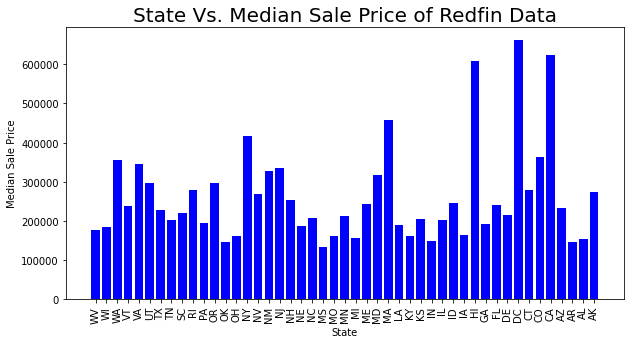

In [ ]:
# convert dataframe to dictionary 
# Visualizing State vs. Median Sale Price of Redfin Data
import matplotlib.pyplot as plt
dict = df_5.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='b')
plt.xlabel("State",fontsize=10)
plt.xticks(rotation=90)
plt.ylabel("Median Sale Price",fontsize=10)
plt.title("State Vs. Median Sale Price of Redfin Data",fontsize=20)
plt.gcf().set_size_inches(10,5)

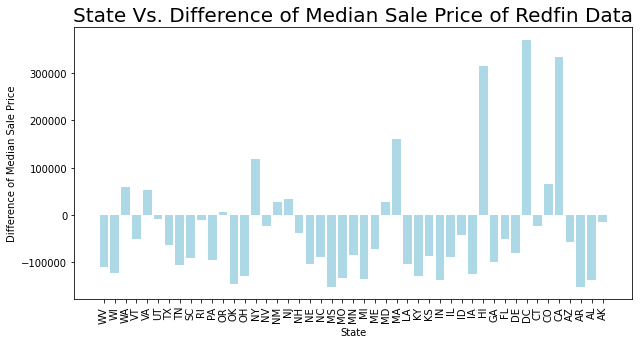

In [ ]:
#Visualizing State vs. Difference of median Sale Price of Redfin data
import matplotlib.pyplot as plt
dict = df_6.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='lightblue')
plt.xlabel("State",fontsize=10)
plt.xticks(rotation=90)
plt.ylabel("Difference of Median Sale Price",fontsize=10)
plt.title("State Vs. Difference of Median Sale Price of Redfin Data",fontsize=20)
plt.gcf().set_size_inches(10,5)

In [ ]:
## https://api.census.gov/data/2020/acs/acs5/variables.html lists all the possible variable keys for the API Request
## Below provides a DF with the ZIP Code and the Median household income.
## Need to initialize spark session first
##CODE
import requests
from pyspark.sql.types import *
from pyspark.sql.functions import from_json
import pandas as pd
from pyspark.sql.functions import col


variables = 'B19013_001E'
year = 2012
key  = '46d133e794f5998e012ea4e0d83d6fb6085136b0'
geography = 'zip%20code%20tabulation%20area'
start_year = 2012
end_year = 2020


while year != end_year + 1:
  census_API_call = requests.get(f'https://api.census.gov/data/{year}/acs/acs5?get={variables}&for={geography}:*&key={key}')
  census_JSON = census_API_call.json()
  df = pd.DataFrame(census_JSON[1:], columns = census_JSON[0])
  #print(df)
  sparkDF = spark.createDataFrame(df)
  #sparkDF.show()
  column_title = f"Median_Inc_{year}"
  if year == start_year:
    updated_df = sparkDF.select(col("zip code tabulation area").alias("Zip_Code"),col("B19013_001E").alias(column_title) )
  else:
    updated_df = updated_df.join(sparkDF,sparkDF['zip code tabulation area']== updated_df.Zip_Code,'left').select(updated_df ["*"],sparkDF['B19013_001E'].alias(column_title))
  
  #print(year)
  year += 1

updated_df.show()

+--------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|Zip_Code|Median_Inc_2012|Median_Inc_2013|Median_Inc_2014|Median_Inc_2015|Median_Inc_2016|Median_Inc_2017|Median_Inc_2018|Median_Inc_2019|Median_Inc_2020|
+--------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|   02053|         108181|         106132|         109841|         110241|         109865|         115432|         119450|         132823|         139688|
|   02090|         130824|         128984|         128813|         135884|         140355|         146042|         155887|         160329|         159776|
|   03442|          65048|          58750|          66125|          63958|          59205|          59881|          61818|          60000|          62802|
|   03904|          53137|          63378|          59521|          61

In [ ]:
census_median_inc = updated_df.withColumnRenamed('Zip_Code', 'Zip_Code')\
.withColumnRenamed('Median_Inc_2012', 'Median_Income_2012').withColumnRenamed('Median_Inc_2013', 'Median_Income_2013')\
                              .withColumnRenamed('Median_Inc_2014', 'Median_Income_2014')\
                              .withColumnRenamed('Median_Inc_2015', 'Median_Income_2015')\
                              .withColumnRenamed('Median_Inc_2016', 'Median_Income_2016')\
                              .withColumnRenamed('Median_Inc_2017', 'Median_Income_2017')\
                              .withColumnRenamed('Median_Inc_2018', 'Median_Income_2018')\
                              .withColumnRenamed('Median_Inc_2019', 'Median_Income_2019')\
                              .withColumnRenamed('Median_Inc_2020', 'Median_Income_2020'


In [ ]:
# Join two dataframes to reflect the sales price and median income based on the zipcode
df_merged = df_zipcode.join(updated_df, 'ZIP_Code',)\
                                                .select(df_zipcode['ZIP_Code'], 
                                                df_zipcode['median_sale_price'],
                                                df_zipcode['median_list_price'],
                                                df_zipcode['property_type'],
                                                df_zipcode['period_begin'],
                                                df_zipcode['homes_sold'],
                                                df_zipcode['state'], 
                                                updated_df['Median_Inc_2012'],
                                                updated_df['Median_Inc_2013'],
                                                updated_df['Median_Inc_2014'],
                                                updated_df['Median_Inc_2015'],
                                                updated_df['Median_Inc_2016'],
                                                updated_df['Median_Inc_2017'],
                                                updated_df['Median_Inc_2018'],
                                                updated_df['Median_Inc_2019'],
                                                updated_df['Median_Inc_2020']).sort(df_zipcode.period_begin.asc())

In [ ]:
df_merged.show(5)

+--------+-----------------+-----------------+--------------------+------------+----------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|ZIP_Code|median_sale_price|median_list_price|       property_type|period_begin|homes_sold|        state|Median_Inc_2012|Median_Inc_2013|Median_Inc_2014|Median_Inc_2015|Median_Inc_2016|Median_Inc_2017|Median_Inc_2018|Median_Inc_2019|Median_Inc_2020|
+--------+-----------------+-----------------+--------------------+------------+----------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|   02053|            90000|             null|Multi-Family (2-4...|  2012-01-01|         1|Massachusetts|         108181|         106132|         109841|         110241|         109865|         115432|         119450|         132823|         139688|


In [ ]:
census_median_inc = census_median_inc.withColumn('Median_Delta', abs(census_median_inc.Median_Income_2020 - census_median_inc.Median_Income_2012))
census_median_inc.show(5)

+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+
|Zip_Code|Median_Income_2012|Median_Income_2013|Median_Income_2014|Median_Income_2015|Median_Income_2016|Median_Income_2017|Median_Income_2018|Median_Income_2019|Median_Income_2020|Median_Delta|
+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+
|   02053|            108181|            106132|            109841|            110241|            109865|            115432|            119450|            132823|            139688|     31507.0|
|   02090|            130824|            128984|            128813|            135884|            140355|            146042|            155887|            160329|            159776|     28952.0|
|   03442|             65

In [ ]:
sales_median_price = df_avg_by_zip.withColumn('Sales_Delta', abs(df_avg_by_zip['2020'] - df_avg_by_zip['2012']))
sales_median_price.show(5)

+--------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|ZIP_Code|              2012|             2013|              2014|              2015|              2016|              2017|              2018|              2019|             2020|              2021|       Sales_Delta|
+--------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|   64747|           84600.0|87279.16666666667|           90094.0|        107729.375|133957.14285714287|118318.33333333333| 145698.2142857143|168377.08333333334|161435.7142857143|197565.21739130435| 76835.71428571429|
|   27248|              null|             null| 72294.42857142857| 93358.33333333333|128041.66666666667|           82375.0|12355

In [ ]:


sales_pop_delta = census_median_inc.join(sales_median_price,sales_median_price['ZIP_Code']==census_median_inc['Zip_code'])\
.select(sales_median_price['ZIP_Code'],census_median_inc['Median_Delta'],sales_median_price['Sales_Delta'])\
.na.drop()\
.sort(sales_median_price['ZIP_Code'])




In [ ]:
print(sales_pop_delta.count())

13412


In [ ]:
import matplotlib.pyplot as plt

delta_plot = sales_pop_delta.select(sales_pop_delta['Median_Delta'],sales_pop_delta['Sales_Delta']).toPandas()
#delta_plot.head()
import numpy as np
from scipy import stats
delta_plot = delta_plot[(np.abs(stats.zscore(delta_plot)) < 3).all(axis=1)]


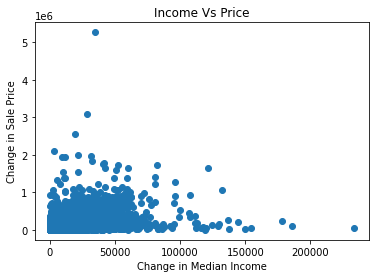

In [ ]:

x = delta_plot.Median_Delta
y = delta_plot.Sales_Delta

plt.scatter(x, y)

plt.ylabel('Change in Sale Price')
plt.xlabel('Change in Median Income')
plt.title('Income Vs Price')
plt.get_scale_names()
plt.yscale('linear')

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

data_no_outliers= spark.createDataFrame(delta_plot)

vectorAssembler = VectorAssembler(inputCols = ['Median_Delta'], outputCol = 'features')
vectored_df = vectorAssembler.transform(data_no_outliers)
vectored_df = vhouse_df.select(['features', 'Sales_Delta'])
vectored_df.show(3)


+---------+-----------------+
| features|      Sales_Delta|
+---------+-----------------+
| [4204.0]|98232.45967741936|
|[17195.0]|373445.8333333333|
|[-4314.0]|          15100.0|
+---------+-----------------+
only showing top 3 rows



In [ ]:
lr = LinearRegression(featuresCol = 'features', labelCol='Sales_Delta', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(vectored_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [3.20389108570053e-05]
Intercept: 156995.86298593535
